In [1]:
import numpy as np
import matplotlib.pyplot as plt

def read_csv(f,header = False,skip = 1):
    F = open(f,"r")
    out = []
    n = -1
    for l in F:
        n += 1
        if n%skip == 0:
            temp = l.split(",")
            if header and n == 0:
                continue#out.append([t.split("\n")[0] for t in temp])
            else:
                out.append([float(t.split("\n")[0]) for t in temp])

        
    out = np.array(out)[:1000*int(len(out)/1000)]
    print(out.shape)
    return out

In [2]:
test_data = np.loadtxt("./test_curves.csv")
model_output = np.reshape(read_csv("./tuning_curveswgan_FF_40_40_new.csv",header=True),[-1,1000,27])

(1999000, 27)


In [3]:
print(test_data.shape)
print(model_output.shape)

(258, 27)
(1999, 1000, 27)


In [4]:
from scipy.stats import ks_2samp as KS
from sklearn import linear_model

#things to define: r-squared, complexity, sparsity

def sparsity(tc):
    l1 = len([t for t in tc if t < 5])
    return float(l1)/len(tc)

def rsquared(tc,getp = False):
    tcrs = np.copy(np.reshape(tc,[3,3,3,1]))
    coord = np.array([[[[x,y,z] for x in range(3)] for y in range(3)] for z in range(3)])
    
    comb = np.concatenate([coord,tcrs],axis = -1)
    tcf = np.reshape(comb,[-1,4])
    LF = linear_model.LinearRegression()
    
    LF.fit(tcf[:,:3],tcf[:,-1])
    
    rs = LF.score(tcf[:,:3],tcf[:,-1])
    if getp:
        proj = [[np.dot(LF.coef_,t[:3]),t[-1]] for t in tcf]
        proj.sort(key = lambda x:x[0])
        proj = np.array(proj)
        proj[:,0] -= np.min(proj[:,0])
        proj[:,0] /= (np.max(proj[:,0]) - np.min(proj[:,0]) + .001)
        return np.copy(proj)
    return rs

def com(tc):
    
    tcrs = np.copy(np.reshape(tc,[3,3,3,1]))
    tcrs = (tcrs - tcrs.mean())/(tcrs.max() - tcrs.min() + .001)
    
    dif = np.stack([np.ravel(tcrs[1:]-tcrs[:-1]),np.ravel(tcrs[:,1:]-tcrs[:,:-1]),np.ravel(tcrs[:,:,1:]-tcrs[:,:,:-1])])
    return np.std(np.abs(dif))

In [5]:
sk = 100

def good(t):
    a = (np.max(t)>5)
    b = ((np.max(t) - np.min(t)) > .01)
    return (a and b)

test_sp = [sparsity(t) for t in test_data]
model_sp = [[sparsity(t) for t in m] for m in model_output[::sk]]

KSsp = [KS(test_sp,m)[0] for m in model_sp]

test_RS = [rsquared(t) for t in test_data if good(t)]
model_RS = [np.array([rsquared(t) for t in m if good(t)]) for m in model_output[::sk]]

test_PR = np.array([rsquared(t,getp = True) for t in test_data if good(t)])
model_PR = np.array([np.array([rsquared(t,getp = True) for t in m if good(t)]) for m in model_output[::sk]])

KSrs = [KS(test_RS,m)[0] for m in model_RS]


test_C = [com(t) for t in test_data if good(t)]
model_C = [np.array([com(t) for t in m if good(t)]) for m in model_output[::sk]]

KSC = [KS(test_C,m)[0] for m in model_C]

test_R = [np.mean(r) for r in test_data]
model_R = [np.array([np.mean(r) for r in m]) for m in model_output[::sk]]

KSR = [KS(test_R,m)[0] for m in model_R]


(925, 27, 2)


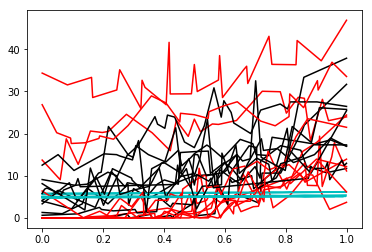

In [6]:
print(model_PR[-1].shape)



plt.clf()
for k in range(10):
    plt.plot(test_PR[k,:,0],test_PR[k,:,1],"k")
    plt.plot(model_PR[-1][k,:,0],model_PR[-1][k,:,1],"r")
    plt.plot(model_PR[0][k,:,0],model_PR[0][k,:,1],"c")
plt.show()

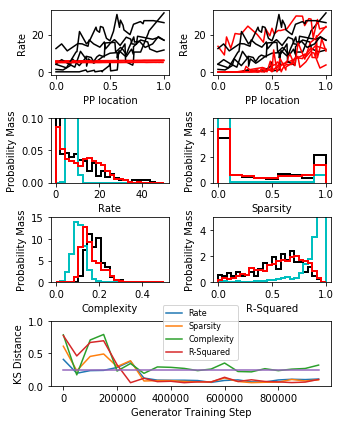

In [7]:
plt.clf()

fig = plt.figure(figsize = (5,6))
#ax = fig.add_axes([0,0,1,1])

ax1 = fig.add_axes([.15,.08,.78,.15])

ax2 = fig.add_axes([.15,.32,.33,.15])
ax3 = fig.add_axes([.6,.32,.33,.15])
ax4 = fig.add_axes([.15,.55,.33,.15])
ax5 = fig.add_axes([.6,.55,.33,.15])

ax6 = fig.add_axes([.15,.8,.33,.15])
ax7 = fig.add_axes([.6,.8,.33,.15])

gs = [500 * s * sk for s in range(len(KSR))]

ax1.plot(gs,KSR,label = "Rate")
ax1.plot(gs,KSsp,label = "Sparsity")
ax1.plot(gs,KSC,label = "Complexity")
ax1.plot(gs,KSrs,label = "R-Squared")
ax1.plot([gs[0],gs[-1]],[.25,.25])
ax1.set_xlabel("Generator Training Step")
ax1.set_ylabel("KS Distance")
ax1.set_ylim([0,1])
ax1.legend(loc = [.4,.4],fontsize = 8)

norm = True
nbin = 25

ax2.hist(test_C,np.linspace(0,.5,nbin),histtype = "step",normed = norm,color = "k",linewidth = 2)
ax2.hist(model_C[0],np.linspace(0,.5,nbin),histtype = "step",normed = norm,color = "c",linewidth = 2)
ax2.hist(model_C[-1],np.linspace(0,.5,nbin),histtype = "step",normed = norm,color = "r",linewidth = 2)
ax2.set_xlabel("Complexity")
ax2.set_ylabel("Probability Mass")
ax2.set_ylim([0,15])

ax3.hist(test_RS,np.linspace(0,1,nbin),histtype = "step",normed = norm,color = "k",linewidth = 2)
ax3.hist(model_RS[0],np.linspace(0,1,nbin),histtype = "step",normed = norm,color = "c",linewidth = 2)
ax3.hist(model_RS[-1],np.linspace(0,1,nbin),histtype = "step",normed = norm,color = "r",linewidth = 2)
ax3.set_xlabel("R-Squared")
ax3.set_ylabel("Probability Mass")
ax3.set_ylim([0,5])

ax4.hist(test_R,np.linspace(0,50,nbin),histtype = "step",normed = norm,color = "k",linewidth = 2)
ax4.hist(model_R[0],np.linspace(0,50,nbin),histtype = "step",normed = norm,color = "c",linewidth = 2)
ax4.hist(model_R[-1],np.linspace(0,50,nbin),histtype = "step",normed = norm,color = "r",linewidth = 2)
ax4.set_xlabel("Rate")
ax4.set_ylabel("Probability Mass")
ax4.set_ylim([0,.1])

ax5.hist(test_sp,np.linspace(0,1,10),histtype = "step",normed = norm,color = "k",linewidth = 2)
ax5.hist(model_sp[0],np.linspace(0,1,10),histtype = "step",normed = norm,color = "c",linewidth = 2)
ax5.hist(model_sp[-1],np.linspace(0,1,10),histtype = "step",normed = norm,color = "r",linewidth = 2)
ax5.set_xlabel("Sparsity")
ax5.set_ylabel("Probability Mass")
ax5.set_ylim([0,5])

for k in range(5):
    ax7.plot(test_PR[k,:,0],test_PR[k,:,1],"k")
    ax7.plot(model_PR[-1][k,:,0],model_PR[-1][k,:,1],"r")
    ax7.set_xlabel("PP location")
    ax7.set_ylabel("Rate")

for k in range(5):
    ax6.plot(test_PR[k,:,0],test_PR[k,:,1],"k")
    ax6.plot(model_PR[0][k,:,0],model_PR[0][k,:,1],"r")
    ax6.set_xlabel("PP location")
    ax6.set_ylabel("Rate")

plt.show()
#plt.savefig("./Fig3_pythonversion.pdf")